In [2]:
import numpy as np
import ROOT
import matplotlib.pyplot as plt
import pandas as pd

# load the macro functions we want to use to create the branches 
# we want on the filtered RDFs
from rootMacros import makeROOTFunctions
makeROOTFunctions()

ModuleNotFoundError: No module named 'ROOT'

### Tile Setup

In [ ]:
# each asic is 4x4 channels
channelXdim = 4
channelYdim = 4

# each tile is 8x8 ASIC array
arrayXdim = 16 # 8
arrayYdim = 16 # 8

xMAX = 575 # from metadata tree, 11.979 tiles in this direction..
xMIN = 1
yMAX = 1500 # from metadata tree, 31.25 tiles in this direction..
yMIN = 1


xDIM = arrayXdim * channelXdim
yDIM = arrayYdim * channelYdim

In [ ]:
ROOT.EnableImplicitMT()
rdf = ROOT.RDataFrame("event_tree", "../../data_radiogen/1ks_fix/core_1_rtd_input_rtd.root")
print("opened rdf of entries: ", rdf.Count().GetValue())

ROOT.gStyle.SetOptStat(0) # remove the histo box over the label

max_x = rdf.Max("pixel_x").GetValue()
max_y = rdf.Max("pixel_y").GetValue()

min_x = rdf.Min("pixel_x").GetValue()
min_y = rdf.Min("pixel_y").GetValue()
print(f"obtained range: ({min_x}-{max_x}:{min_y}-{max_y})")

colNames = rdf.GetColumnNames()
print("found columns: ", colNames)

opened rdf of entries:  75695206
obtained range: (0.0-575.0:0.0-1500.0)
found columns:  { "pixel_reset", "pixel_reset_truth_track_id", "pixel_reset_truth_weight", "pixel_x", "pixel_y" }


#### Root setup

In [ ]:
# make sure we can rerun this cell
tref = None
tref = ROOT.TFile("ref.root", "UPDATE")
dicts = {}

def assignDirs(tfile, dirname):
    assert isinstance(dirname, str), "must give strings as directory names"
    if not hasattr(tref, dirname):
        d = tfile.mkdir(dirname)
    else:
        d = getattr(tfile, dirname)
    return d

dictNames = ["canvas", "hists", "dataframes"] 
dicts = {x:assignDirs(tref,x) for x in dictNames}

def savehist(h, loc=dicts):
    assert loc.get('hists') != None, "missing TDirectory location to store hist"
    d = loc['hists']
    d.cd()
    h.Write()
    return h

## Data Extraction
place into electron pie graph
find average RTD for all inputs
find average RTD for isotopes that were the major factor of the rtd

displaying resets in all channels


Info in <TCanvas::Print>: png file ./pdfs/fullApaResets.png has been created


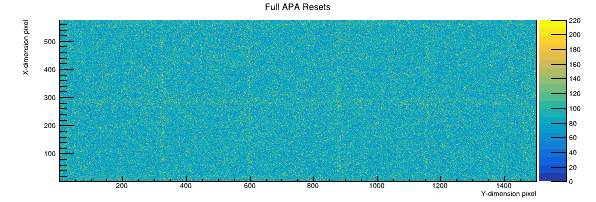

In [ ]:
print("displaying resets in all channels")
c = ROOT.TCanvas("c1", "c1", 600, 230)
h = rdf.Histo2D(("h", "ht", int(max_y), 1., max_y, int(max_x), 1., max_x), "pixel_y", "pixel_x")
h.Draw("colz")
h.SetTitle("Full APA Resets")
c.Draw()
h.GetXaxis().SetTitle("Y-dimension pixel")
h.GetYaxis().SetTitle("X-dimension pixel")
c.SaveAs("./pdfs/fullApaResets.png")
# ROOT.c1.Draw()
# h = savehist(h)

4
575.0 1500.0
374.75
143.75 375.0 35.75


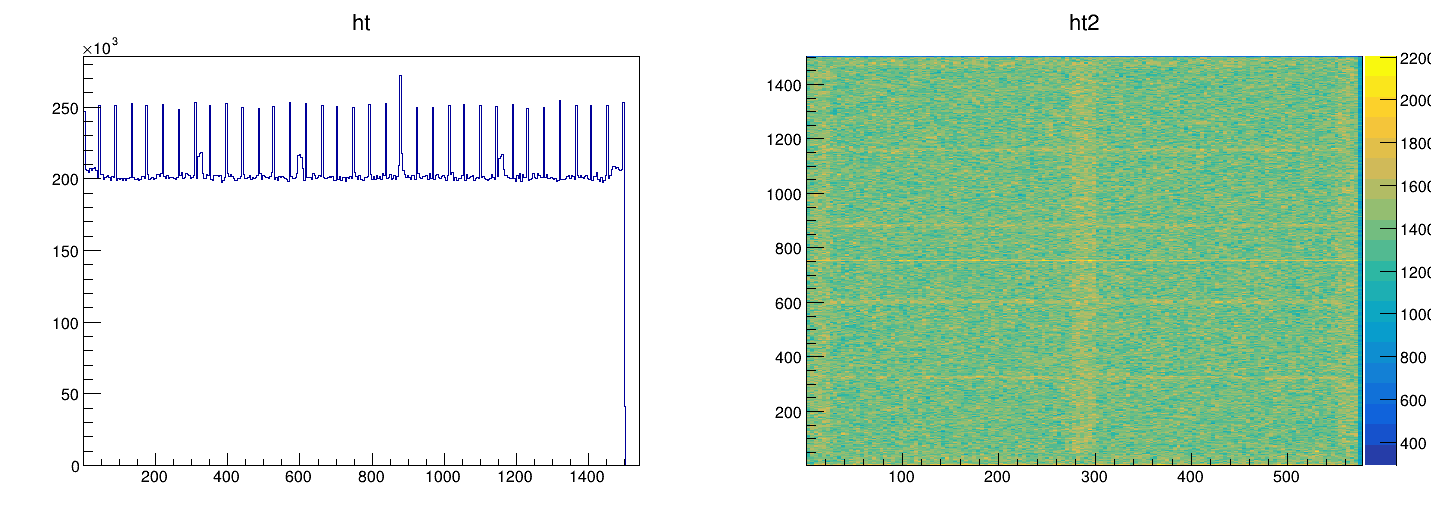

In [ ]:
c = ROOT.TCanvas("c", "c", 1450, 550)
c.Divide(2,1)
c.cd(1)
print(channelYdim)
print(max_x, max_y)
print(1499/channelYdim)
print(575/channelXdim, 1500/channelYdim, 143/channelYdim)
h = rdf.Histo1D(("h", "ht", int(1500/channelYdim)+1, 1., max_y+40), "pixel_y")
h.Draw("colz")
c.cd(2)
h2 = rdf.Histo2D(("h2", "ht2", int(575/channelYdim )+1, 1., max_x+2, int(1500/channelYdim), 1, max_y+3), "pixel_x", "pixel_y")
h2.Draw("colz")
c.Draw()

## Show the electron and reset densities

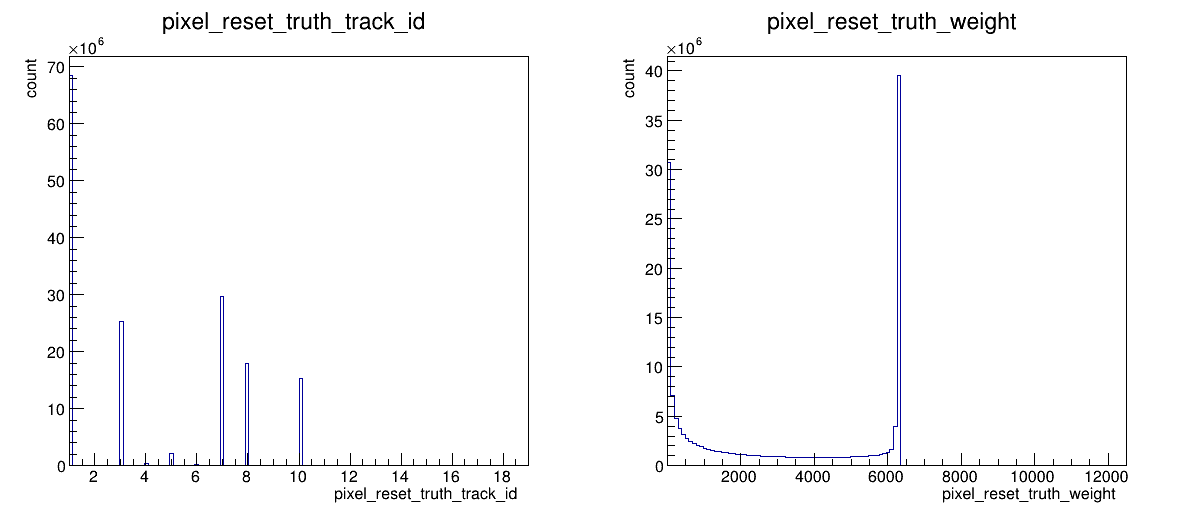

In [ ]:
def showElectrons(input_df):
    """
    """
    fdf = input_df.Filter("pixel_x != 0 && pixel_y != 0")
    
    # must keep the canvas and hist objects alive to display
    cv = ROOT.TCanvas("cv", "cv", 1200, 550)
    cv.Divide(2)
    hs = []
    
    cv.cd(1)    
    hs.append(fdf.Histo1D("pixel_reset_truth_track_id"))
    hs[-1].Draw()
    
    cv.cd(2)
    hs.append(fdf.Histo1D("pixel_reset_truth_weight"))
    hs[-1].Draw()
    
    cv.Draw()
    return cv, hs

if True:
    b = showElectrons(rdf)

In [ ]:
def makeWeight(input_df):
    """
    take the base input dataframe, and make sure that we don't have
    any impossible track_ids
    make the responsible defines
    """
    names = ["Ar39", "Ar42", "Bi214", "Co60", "K40", "K42", "Kr85", "Pb214", "Po210", "Rn222"]
    print("creating column names: ", names)
    fdf = input_df.Filter("pixel_x != 0 && pixel_y != 0")
    for name in names:
        fdf = fdf.Define(f"{name}", f"defineBranch(\"{name}\", pixel_reset_truth_weight, pixel_reset_truth_track_id)")
    
    ce = ROOT.TCanvas("ce", "ce", 1200, 2550)
    hs = []
    ce.Divide(2,5)
    for i, name in enumerate(names):
        ce.cd(i+1)
        tdf = fdf.Filter(f"{name} > 0")
        print(f"{name} has counts: ", tdf.Count().GetValue()) 
        hs.append(tdf.Histo1D(f"{name}"))
        hs[-1].Draw()
        

    ce.Draw()
    return ce, hs

if False:
    b = makeWeight(rdf)

## Find the most active tile, and convert this into a json file for further simulation

In [ ]:
def findActiveRegion(input_rdf, arrayXdim=arrayXdim, arrayYdim=arrayYdim):

    # scan through the detector volume
    xITR = range(xMIN, xMAX, xDIM)
    yITR = range(yMIN, yMAX, yDIM)

    # lots of zero positions
    bestPos = 0
    bestX, bestY = 0, 0
    for x in xITR:
        for y in yITR:
            fdf = input_rdf.Filter(f"pixel_x >= {x} && pixel_x < {x+xDIM}")\
                           .Filter(f"pixel_y >= {y} && pixel_y < {y+yDIM}")
            nResets = fdf.Count().GetValue()
            if nResets > bestPos:
                bestPos = nResets
                bestX = x
                bestY = y
    return bestX, bestY, bestPos

In [ ]:
if True:
    bestX, bestY, bestPos = findActiveRegion(rdf)
    print(f"found most active position: ({bestX},{bestY}) with {bestPos} hits")
else:
    bestX = 281
    bestY = 561
    bestPos = 205640

fdf = rdf.Filter(f"pixel_x >= {bestX} && pixel_x < {bestX+xDIM}")\
         .Filter(f"pixel_y >= {bestY} && pixel_y < {bestY+yDIM}")

found most active position: (257,577) with 372731 hits


In [ ]:
def makeNumpy(filtered_df, time_start=0, time_end=None):
    from math import ceil

    rd_data = filtered_df.AsNumpy(["pixel_x", "pixel_y", "pixel_reset"])
    
    pixel_x = rd_data["pixel_x"]
    pixel_y = rd_data["pixel_y"]
    pixel_reset = rd_data["pixel_reset"]
    
    if time_end is not None:
        good_times = np.logical_and(pixel_reset > time_start, pixel_reset <= time_end)
        pixel_x = pixel_x[good_times]
        pixel_y = pixel_y[good_times]
        pixel_reset = pixel_reset[good_times]
    
    pd_data = {}
    pd_data["pX"] = pixel_x
    pd_data["pY"] = pixel_y
    pd_data["Reset"] = pixel_reset

    df = pd.DataFrame(pd_data)
    # count these as done in Simulation "Top Left" Asic is (0,0) : (row, col)
    # create X
    df['tileX'] = ((df['pX'] - 1) / xDIM).map(int)
    df["AsicX"] = ((df["pX"] - 1) / channelXdim).map(int)

    # create Y
    df['tileY'] = ((df['pY'] - 1) / yDIM).map(int)
    df["AsicY"] = ((df["pY"] - 1) / channelYdim).map(int)

    # create N, unique ASIC / Tile numbers to easily histogram
    df['tileN'] = df['tileX'] + df['tileY'] * ceil(xMAX / xDIM)
    df['AsicN'] = df['AsicX'] + df['AsicY'] * ceil(xMAX / channelXdim)

    # for each asic, it should only number a nPix within it's dimensions channelXdim *channelYdim
    # we chose X-dim as the "row" and Y-dim as the "column", to be consistent with the 
    # coordinates for the tile / simulation dimensions
    npx = ((df["pX"]) - channelXdim*df["AsicX"] - 1).map(int)
    npy = ((df["pY"]) - channelYdim*df["AsicY"] - 1).map(int)
    df["nPix"] = npx + channelYdim*npy
    df["PixN"] = df['pX'] + (df['pY'] ) * xMAX # include -1 since pY is one counted
    
    return df

out_file = "/mnt/c/Users/keefe/OneDrive/Documents/root_temp/jsons/1k_rtd_data.json"
def makeJson(filtered_df, arrayXdim=arrayXdim, arrayYdim=arrayYdim, outf=out_file, time_start=0, time_end=None):
    """
    args: filtered_pd_df - filtered RDataFrame
    """
    fdf = makeNumpy(filtered_df, time_start, time_end)
    
    # create the tile's dataframe to send into the QPixAsicArray
    tiledf = {}
    tiledf["nrows"] = arrayXdim
    tiledf["ncols"] = arrayYdim
    tiledf["hits"] = []

    # normalize asic numbers: this is for the simulation input which "0 numbers" the asic's within it's rows / cols
    hitX = fdf["AsicX"].unique()
    hitY = fdf["AsicY"].unique()
    minX = min(hitX)
    minY = min(hitY)

    # build the hits tuple for each asic within the tile
    nHits = 0
    for x in hitX:
        for y in hitY:
            asicResets = fdf[ (fdf["AsicX"] == x) & (fdf["AsicY"] == y) ][["Reset","nPix"]].values.tolist()
            arrayX = x if minX == 0 else int(x%minX)
            arrayY = y if minY == 0 else int(y%minY)
            if time_end is not None:
                asicResets = np.array(asicResets) - time_start
                asicResets = asicResets.tolist()
            tiledf["hits"].append([arrayX, arrayY, list(asicResets)])
            nHits += len(asicResets)

    print("creating file with hits:", nHits)        
    # store the values within a json file
    import json
    with open(outf, "w") as outputFile:
        json.dump(tiledf, outputFile, indent=4)
        print("saved file", outf)
        outputFile.close()

In [ ]:
out_file = "/mnt/c/Users/keefe/OneDrive/Documents/root_temp/jsons/1k_rtd_data_200-210.json"
if True:
    makeJson(fdf)
    makeJson(fdf, outf=out_file, time_start=200, time_end=210)

creating file with hits: 372731
saved file /mnt/c/Users/keefe/OneDrive/Documents/qpix-digital/simulation-rtd/hits/1k_rtd_data.json
creating file with hits: 3825
saved file /mnt/c/Users/keefe/OneDrive/Documents/qpix-digital/simulation-software/1k_rtd_data_200-210.json
